# Automatic differentiation: a backpropagation example for genetic programming

The purpose of this notebook is to demonstrate how weights can be learned for programs made up of differentiable nodes. In this case we're concerned with stack-based representations of mathematical functions, such as 

[ x1 x2 + sin ] $\rightarrow sin(x1+x2)$

or with embedded weights, $w_4 \cdot \sin( w_3 \cdot ( w_1 \cdot x_1 + w_2 \cdot x_2) ) $

In [12]:
# define node classes
# Deal with elements that aren't differentiable (keep executing branch but skip past that value)
class Variable():
    def __init__(self,loc=0):
        self.loc = loc
        self.name='x_'+str(loc)
        self.arity=0
        self.visits=0
                
    def evaluate(self,stack,X=None):
        stack.append(X[:,self.loc])
    
class Add():
    def __init__(self, W=None):
        self.name='+'
        self.arity=2
        self.visits=0
        
        # Technically have vulnerability to lists of non numbers
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(self.W[0]*stack.pop() + self.W[1]*stack.pop())
        
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
            
        if loc == 0: stack.append(self.W[0] + self.W[1] * fwd_stack[-2])
        else: stack.append(self.W[0] * fwd_stack[-1] + self.W[1])
        
    def update(self,derivatives,fwd_stack,n):
        update_value = 1;
        for d in derivatives[:]: # Calculate the chain rule
            update_value *= d;
        
        W = self.W # don't want weight update to cascade and change gradient for other weights
        d_w = fwd_stack[-1] + W[1] * fwd_stack[-2]
        self.W[0] = W[0] - n/update_value.size * sum(d_w * update_value)
        value = W[1] - n/update_value.size * sum(d_w * update_value)
        print("Add updating W0 with", value, ' to value: ', self.W[0])
        d_w = W[0] * fwd_stack[-1] + fwd_stack[-2]
        self.W[1] = W[1] - n/update_value.size * sum(d_w * update_value)
        value = n/update_value.size * sum(d_w * update_value)
        print("Add updating W1 with", value, ' to value: ', self.W[1])
        
        
class Subtract():
    def __init__(self,W=None):
        self.name='-'
        self.arity=2
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
        
    def evaluate(self,stack,X=None):
        stack.append(self.W[0]*stack.pop() - self.W[1]*stack.pop())
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
            
        if loc == 0: stack.append(self.W[0] - self.W[1] * fwd_stack[-2])
        else: stack.append(self.W[0] * fwd_stack[-1] - self.W[2])
        
    def update(self,derivatives,fwd_stack,n):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
            
        W = self.W
        d_w = fwd_stack[-1] - W[1] * fwd_stack[-2]
        self.W[0] = W[0] - n/update_value.size * sum(d_w * update_value)
        value = W[1] - n/update_value.size * sum(d_w * update_value)
        print("Subtract updating W0 with", value, ' to value: ', self.W[0])
        d_w = W[0] * fwd_stack[-1] - fwd_stack[-2]
        self.W[1] = W[1] - n/update_value.size * sum(d_w * update_value)
        value = n/update_value.size * sum(d_w * update_value)
        print("Subtract updating W1 with", value, ' to value: ', self.W[1])
        
class Multiply():
    def __init__(self,W=None):
        self.name='*'
        self.arity=2
        self.error=0
        self.visits=0
        
        if isinstance(W, list) and len(W) == self.arity - 1: self.W = W
        else: self.W = [1.0, 1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(self.W[0] * stack.pop() *stack.pop())
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
        stack.append(self.W[0] * fwd_stack[-(loc + 1)]) 
        
    def update(self,derivatives,fwd_stack,n):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        W = self.W
        d_w = fwd_stack[-1] * W[1] * fwd_stack[-2]
        self.W[0] = W[0] - n/update_value.size * sum(d_w * update_value)
        d_w = self.W[0] * fwd_stack[-1] * fwd_stack[-2]
        self.W[1] = W[1] - n/update_value.size * sum(d_w * update_value)

class Divide():
    def __init__(self,W=None):
        self.name='/'
        self.arity=2
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
 
    def evaluate(self,X,stack):
        stack.append(self.W[0] * stack.pop()/(self.W[1] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
            
        if loc==0: stack.append(self.W[0]/fwd_stack[-2])
        else: stack.append(-self.W[0] * fwd_stack[-1]/(self.W[1] * fwd_stack[-2]**2))
        
    def update(self,derivatives,fwd_stack,n):            
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        W = self.W
        d_w = fwd_stack[-1]/(W[1] * fwd_stack[-2])
        self.W[0] = W[0] - n/update_value.size * sum(d_w * update_value)
        d_w = -W[0] * fwd_stack[-1]/(fwd_stack[-2] * W[1]**2)
        self.W[1] = W[1] - n/update_value.size * sum(d_w * update_value)      
 
class Sin():
    def __init__(self,W=None):
        self.name='sin'
        self.arity=1
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
        
    def evaluate(self,stack,X=None):
        stack.append(np.sin(self.W[0] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
        stack.append(self.W[loc] * np.cos(self.W[loc] * fwd_stack[-1]))
        
    def update(self,derivatives,fwd_stack,n,loc=-1):
        update_value = 1;
        for d in derivatives[:]:
            update_value *= d;
        d_w = fwd_stack[-1] * np.cos(self.W[loc] * fwd_stack[-1])
        self.W[loc] = self.W[loc] - n/update_value.size * sum(d_w * update_value)
        value = n/update_value.size * sum(d_w * update_value)
        print("Sin updating W with", value, ' to: ', self.W[0])
        
class Cos():
    def __init__(self,W=None):
        self.name='cos'
        self.arity=1
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(np.cos(self.W[0] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
        stack.append(self.W[loc] * -np.sin(self.W[loc] * fwd_stack[-1])) 
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives[:]:
            update_value *= d;
        
        d_w = fwd_stack[-1] * -np.sin(self.W[0] * fwd_stack[-1])
        self.W[loc] = self.W[loc] - n/update_value.size * sum(d_w * update_value)
        value = n/update_value.size * sum(d_w * update_value)
        print("Cos updating W with", value, ' to value: ', self.W[0])
        
class Logit():
    def __init__(self,W=None):
        self.name='logit'
        self.arity=1
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(1/(1 + np.exp(-self.W[0] * stack.pop())))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
            
        numerator = self.W[0] * np.exp(-self.W[0] * fwd_stack[-1])
        denom = (1 + np.exp(-self.W[0] * fwd_stack[-1]))**2
        stack.append(numerator/denom)
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
                 
        numerator = fwd_stack[-1] * np.exp(-self.W[0] * fwd_stack[-1])
        denom = (1 + np.exp(-self.W[0] * fwd_stack[-1]))**2
        d_w = numerator/denom
        self.W[loc] = self.W[loc] - n/update_value.size * sum(d_w * update_value)
        value = n/update_value.size * sum(d_w * update_value)
        print("Logit updating W0 with", (n/update_value.size * sum(d_w * update_value)), ' to value: ', self.W[0])
      
# How do we deal with multiple outputs in the context of the program?
class Softmax2(): # Vector operating node - takes in 2 inputs and outputs wrt 1st
    def __init__(self,W=None):
        self.name='softmax'
        self.arity=arity
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0 for x in range(len(arity))]
            
    def evaluate(self,stack,X=None):
        values = [np.exp(self.W[i] * stack.pop()) for i in range(self.arity)]        
        stack.append(value[1]/sum(values))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
        
        if loc == 0:
            numerator = self.W[0] * np.exp(self.W[0] * fwd_stack[-1] + self.W[1] * fwd_stack[-2])
            denom = (np.exp(self.W[0] * fwd_stack[-1]) + np.exp(self.W[1] * fwd_stack[-2]))**2
            stack.append(numerator/denom)
        elif loc == 1:
            numerator = self.W[1] * np.exp(self.W[0] * fwd_stack[-1] + self.W[1] * fwd_stack[-2])
            denom = (np.exp(self.W[0] * fwd_stack[-1]) + np.exp(self.W[1] * fwd_stack[-2]))**2
            stack.append(numerator/denom)
        
    def update(self,derivatives,fwd_stack,n):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        W = self.W
        numerator = fwd_stack[-1] * np.exp(W[0] * fwd_stack[-1] + W[1] * fwd_stack[-2])
        denom = (np.exp(W[0] * fwd_stack[-1]) + np.exp(W[1] * fwd_stack[-2]))**2
        d_w = numerator/denom
        self.W[0] = W[0] - n/update_value.size * sum(d_w * update_value)
        numerator = W[1] * np.exp(W[0] * fwd_stack[-1] + W[1] * fwd_stack[-2])
        denom = (np.exp(W[0] * fwd_stack[-1]) + np.exp(W[1] * fwd_stack[-2]))**2
        d_w = numerator/denom
        self.W[1] = W[1] - n/update_value.size * sum(d_w * update_value)
        
class Tanh():
    def __init__(self,W=None):
        self.name='tanh'
        self.arity=1
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        z = self.W[0] * stack.pop();
        stack.append((np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z)))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity: loc = 0
        
        numerator = 4 * self.W[0] * np.exp(2 * self.W[0] * fwd_stack[-1])
        denom = (np.exp(2 * self.W[0] * fwd_stack[-1]) + 1)**2
        stack.append(numerator/denom)
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        numerator = 4 * self.W[0] * np.exp(2 * self.W[0] * fwd_stack[-1])
        denom = (np.exp(2 * self.W[0] * fwd_stack[-1]) + 1)**2
        d_w = numerator/denom
        
        self.W[loc] = self.W[loc] - n/update_value.size * sum(d_w * update_value)

In [13]:
# Cost Functions
class CostSquaredDifference():
    def __init__(self,labels=None):
        self.visits=0
        self.arity=2
        self.name="Squared Error Cost"
        try: 
            _ = labels.shape
            self.arity=1
            self.labels=labels
        except:
            self.labels=labels
        
    def set_labels(self, labels):
        try: 
            _ = labels.shape
            self.arity=1
        except:
            self.labels=None
            self.arity=2
    
    def evaluate(self,Y_hat,Y=None):
        try: 
            result = (Y_hat - Y)**2
        except:
            result = (Y_hat - self.labels)**2
            
        return result
    
    def derivative(self,Y_hat,Y=None):
        try: 
            result = 2*(Y_hat - Y)
        except:
            result = 2*(Y_hat - self.labels)
        return result
    
    def update(self,derivative,fwd_stack,n,loc):
        pass    

In [14]:
import copy

class Auto_backprop():
    def __init__(self, program, cost_fcn, X, labels, iters=1000, n=0.1):
        self.program = program    # Program to modify (stack)
        self.cost_fcn = cost_fcn  # Determines how error is calculated (expected args are y_hat, y)
        self.X = X                # Training data (list of values)
        self.labels = labels      # Training labels (list of values)
        self.iters = iters        # Iterations of learning (scalar)
        self.n = n                # Learning Rate (scalar)
        
    def start(self):
        # "Intialize" cost function
        self.cost_fcn.set_labels(self.labels)
        
        # Computes weights via backprop
        for x in range(self.iters):            
            fwd_stack = self.forward_prop()
            if (x % 1) == 0:
                print("Currently on iter: " + str(x))
                print("Error: " + str(np.mean(self.cost_fcn.evaluate(fwd_stack[-1]))))
            self.backprop(fwd_stack)
            
        print("Gradient Descent Complete ------------------------------")
        return self.program
        
    def forward_prop(self):
        # Computes the forward pass of the program as described by the stack
        execution_stack = []
        fwd_stack = []
        
        # Program stack itself is unchanging
        for p in self.program:
            p.visits=0 # Clear our values set by backprop
            
            # Keep track of what computations were needed for execution (for purpose of GD)
            for x in range(p.arity):
                fwd_stack.append(execution_stack[-(p.arity - x)])
                
            p.evaluate(execution_stack, self.X)

        # Add the final prediction to the stack
        fwd_stack.append(execution_stack.pop())
        
        return fwd_stack
    
    # Returns the node and derivative of the parent, returns None if not found
    def get_next_branch(self, executing, bp_program, gradients):
        # Every node should have an associated gradient
        if executing:
            n_derivatives = []
            while not n_derivatives:
                (node, n_derivatives) = executing.pop()
                gradients.pop()
                
                if not executing:
                    return None
            
            # Should now have the next parent node
            bp_program.append(node)
            gradients.append(n_derivatives.pop(0))
            executing.append((node, n_derivatives))
        return None
        
    def backprop(self, fwd_stack):
        # Prepare stacks
        gradients = [self.cost_fcn.derivative(fwd_stack[-1])]
        fwd_stack.pop() # Value is not an input to any function, not needed for derivatives
        
        executing = []
        bp_program = copy.copy(self.program) # Using a counter approach would allow avoiding this
        
        while bp_program:
            node = bp_program.pop() 
            print("Evaluating: ", node.name)
            n_derivatives = []
            if node.visits == 0 and node.arity > 0:
                # New implementation: Calculate all gradients and updates at same time
                # If have arity > 1 then store extra derivatives on executing stack in following manner:
                # Stack holds elements with form: (node, [list of derivatives])
                # Once all derivatives are calculated can throw input values away
                
                for i in range(node.arity):
                    node.derivative(n_derivatives, fwd_stack, node.arity - 1 - i) # Values need to be calculated before updates
                    
                node.update(gradients,fwd_stack,self.n) # Update all weights
                
                # Get rid of all input arguments
                for x in range(node.arity):
                    fwd_stack.pop()
                
                # Add the gradient for the first branch into the current executing gradients
                if n_derivatives:
                    gradients.append(n_derivatives.pop(0))
                # Keep track of all gradients currently on stack
                executing.append((node, n_derivatives))
            
            # Care about tree structure for backpropping gradients
            if node.arity == 0:
                # Clean up gradients and find the parent node
                self.get_next_branch(executing, bp_program, gradients)
            else:
                # Must be an operator
                node.visits += 1 # Consider moving to after
                
                if node.visits > node.arity:         
                    self.get_next_branch(executing, bp_program, gradients)

Error before GD: 0.18504890638192656
Currently on iter: 0
Error: 0.18504890638192656
('Evaluating: ', 'cos')
('Cos updating W with', 0.07220903673714095, ' to value: ', 0.927790963262859)
('Evaluating: ', 'sin')
('Sin updating W with', -0.28489328171772893, ' to: ', 1.284893281717729)
('Evaluating: ', '+')
('Add updating W0 with', 1.284893281717729, ' to value: ', 1.284893281717729)
('Add updating W1 with', -0.3254728649194812, ' to value: ', 1.3254728649194811)
('Evaluating: ', 'x_1')
('Evaluating: ', '+')
('Evaluating: ', 'x_0')
Gradient Descent Complete ------------------------------
Error after GD: 0.0577991541029464


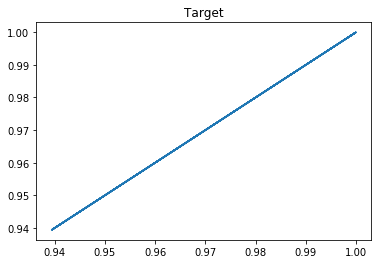

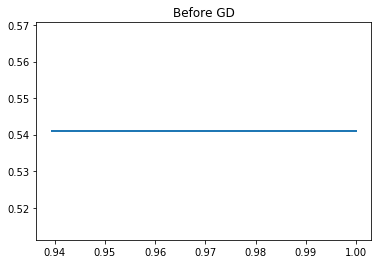

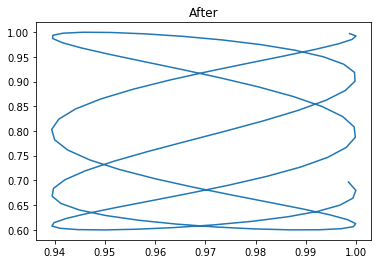

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# X = np.random.rand(100,2)
data1 = np.asarray([1.0 * i for i in range(100)])
data2 = np.flip(data1, 0)
X = np.stack((data1, data2), -1)
# test weights
w1, w2, w3 = 0.35, 0.76, 0.89

# Attempt backpropagation
ytest = np.cos(w1*np.sin(w2*X[:,0] + w3*X[:,1]))
#ytest = np.sin(w1*X[:,0] + w2*X[:,0])
#ytest = np.tanh(0.35 * X[:,0])
prog = [Variable(loc=0), Variable(loc=1), Add(), Sin(), Cos()]
#prog = [Variable(loc=0), Variable(loc=1), Add(), Sin()]
#prog = [Variable(loc=0), Tanh()]
stack = []
for p in prog:
    p.evaluate(stack, X)
yhat2 = np.array(stack[-1])

cost_fcn = CostSquaredDifference(ytest)
error = cost_fcn.evaluate(yhat2)
print('Error before GD: ' + str(np.mean(error)))

GD = Auto_backprop(prog, cost_fcn, X, ytest, 1,0.1)
prog = GD.start()
stack = []
for p in prog:
    p.evaluate(stack, X)
yhat3 = np.array(stack[-1])
error = cost_fcn.evaluate(yhat3)
print('Error after GD: ' + str(np.mean(error)))

h0 = plt.figure()
plt.plot(ytest,ytest)
plt.title('Target')
plt.show()

h1 = plt.figure()
plt.plot(ytest,yhat2)
plt.title('Before GD')
plt.show()

h2 = plt.figure()
plt.plot(ytest,yhat3)
plt.title('After')
plt.show()
